## Approximating A sine function with different activations

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from tqdm import tqdm

class OneNeuronNet(nn.Module):
    def __init__(self, depth: int, activation_fn = nn.ReLU):
        """
        depth: number of hidden layers (each with 1 neuron + ReLU)
        The network has:
          input → [ (Linear → ReLU) × depth ] → Linear → output
        """
        super().__init__()
        layers = []
        layerdim = 32
        # build depth hidden layers of size 1 → 1
        layers.append(nn.Linear(1, layerdim))
        layers.append(activation_fn())
        for _ in range(depth):
            layers.append(nn.Linear(layerdim, layerdim))
            layers.append(activation_fn())
        # final output layer
        layers.append(nn.Linear(layerdim, 1))
        # pack into a Sequential
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
def run_expt(act = nn.ReLU):
    # hyperparameters
    depth = 1
    lr = 1e-2
    epochs = 2000
    batch_size = 64

    # dataset: sample x in [-2π, 2π], target = sin(x)
    def f(x):
      y = torch.sin(x)
      # y = x **2 + (x-2)**3 + x**4 - 12
      return y

    def sample_batch(bs):
        x = (torch.rand(bs, 1) * 4 * math.pi) - 2 * math.pi
        y = f(x)
        return x, y

    model = OneNeuronNet(depth, activation_fn=act)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    pbar = tqdm(range(1, epochs + 1))
    for epoch in pbar:
        x_batch, y_batch = sample_batch(batch_size)
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item())

    # test on a grid
    xs = torch.linspace(-2*math.pi, 4*math.pi, 400).unsqueeze(1)
    with torch.no_grad():
        ys_pred = model(xs).numpy()
    ys_true = f(xs).numpy()
    print(model)

    # simple plot (requires matplotlib)
    import matplotlib.pyplot as plt
    plt.plot(xs.numpy(), ys_true, label="f(x)")
    plt.plot(xs.numpy(), ys_pred, label="NN approx")
    plt.legend()
    plt.title(f"One‐Neuron‐Per‐Layer Net (depth={depth})")
    plt.show()



100%|██████████| 2000/2000 [00:07<00:00, 258.68it/s, loss=0.000244]


OneNeuronNet(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


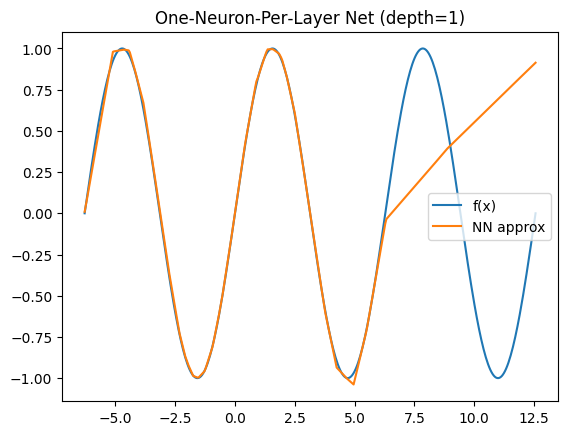

In [ ]:
run_expt(nn.ReLU)

100%|██████████| 2000/2000 [00:07<00:00, 279.03it/s, loss=4.81e-5]


OneNeuronNet(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


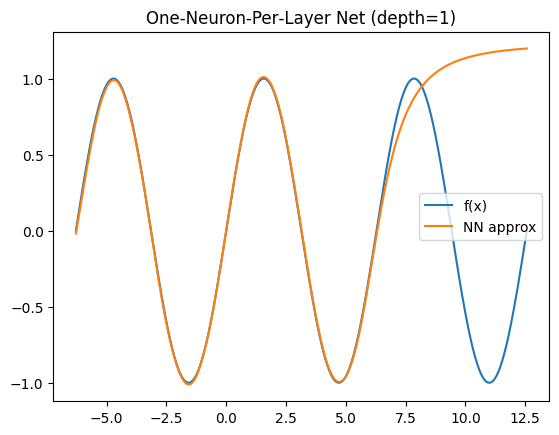

In [ ]:
run_expt(nn.Tanh)

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

# -- Frequency encoding function --
def frequency_encoding(coords: torch.Tensor, num_freqs: int) -> torch.Tensor:
    """
    Apply Fourier feature mapping to 2D coordinates.
    Args:
        coords: Tensor of shape [N, 2] with values in [0,1]
        num_freqs: Number of frequency bands
    Returns:
        encoded coords of shape [N, 2 + 4 * num_freqs]
    """
    if num_freqs <= 0:
        return coords
    # Create frequency bands: [1, 2, 4, ..., 2^(L-1)] * pi
    freqs = (2. ** torch.arange(num_freqs).float() * np.pi).to(coords.device)  # [num_freqs]
    # Expand coords to [N, 1, 2] and multiply by freqs -> [N, num_freqs, 2]
    pts = coords.unsqueeze(1) * freqs.view(1, num_freqs, 1)
    sin = pts.sin()  # [N, num_freqs, 2]
    cos = pts.cos()  # [N, num_freqs, 2]
    sin_flat = sin.view(coords.size(0), -1)  # [N, 2*num_freqs]
    cos_flat = cos.view(coords.size(0), -1)  # [N, 2*num_freqs]
    # Concatenate original coords with sin and cos components
    return torch.cat([coords, sin_flat, cos_flat], dim=-1)


def get_cat_data(root='./data', index_=32):
    transform = transforms.ToTensor()
    cifar10 = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
    cat_imgs = [img for img, lbl in cifar10 if lbl == 3]
    img_tensor = cat_imgs[index_]
    img_np = img_tensor.permute(1, 2, 0).numpy()
    H, W, _ = img_np.shape

    xs = np.linspace(0, 1, W)
    ys = np.linspace(0, 1, H)
    xx, yy = np.meshgrid(xs, ys)
    coords = np.stack([xx, yy], axis=-1).reshape(-1, 2)
    pixels = img_np.reshape(-1, 3)

    coords_t = torch.tensor(coords, dtype=torch.float32)
    pixels_t = torch.tensor(pixels, dtype=torch.float32)
    return img_np, coords_t, pixels_t, H, W


def build_mlp(layer_dims, activation='relu'):
    assert layer_dims[0] == layer_dims[0] and layer_dims[-1] == 3
    acts = {'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'sigmoid': nn.Sigmoid()}
    act = acts[activation]
    layers = []
    for i in range(len(layer_dims)-1):
        layers.append(nn.Linear(layer_dims[i], layer_dims[i+1]))
        if i < len(layer_dims)-2:
            layers.append(act)
    layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)


def train_model(model, coords_t, pixels_t, H, W, num_epochs=200, num_snapshots=6, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    snap_epochs = sorted(set(np.linspace(0, num_epochs, num_snapshots, dtype=int)))
    loss_history, snapshots = [], []

    if 0 in snap_epochs:
        with torch.no_grad():
            out0 = model(coords_t).reshape(H, W, 3).cpu().numpy()
        snapshots.append((0, out0))

    for epoch in range(1, num_epochs+1):
        optimizer.zero_grad()
        preds = model(coords_t)
        loss = criterion(preds, pixels_t)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        if epoch in snap_epochs:
            with torch.no_grad():
                out = model(coords_t).reshape(H, W, 3).cpu().numpy()
            snapshots.append((epoch, out))
            print(f'Epoch {epoch}/{num_epochs}  Loss: {loss.item():.6f}')

    return loss_history, snapshots


def plot_ground_truth(img_np):
    plt.figure(figsize=(4,4))
    plt.imshow(img_np)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.show()


def plot_loss(loss_history, activation):
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(loss_history)+1), loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'Training Loss ({activation})')
    plt.tight_layout()
    plt.show()


def plot_snapshots(img_np, snapshots):
    n = len(snapshots) + 1
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    axes[0].imshow(img_np); axes[0].set_title('GT'); axes[0].axis('off')
    for ax, (ep, im) in zip(axes[1:], snapshots):
        ax.imshow(im); ax.set_title(f'Epoch {ep}'); ax.axis('off')
    plt.tight_layout()
    plt.show()


def run_experiment(layer_dims, activation, num_epochs=200, num_snapshots=6, lr=1e-3, num_freqs=0, index_=32):
    """
    Run MLP experiment with optional Fourier feature encoding.
    Args:
        layer_dims: List of ints, MLP layer sizes (first element will be replaced if num_freqs > 0)
        activation: Activation function name ('relu', 'tanh', 'sigmoid')
        num_epochs: Number of training epochs
        num_snapshots: How many snapshots to collect
        lr: Learning rate
        num_freqs: Number of Fourier frequency bands to encode coords
        index_: Index of cat image in CIFAR-10 test set
    """
    img_np, coords_t, pixels_t, H, W = get_cat_data(index_=index_)

    # Apply frequency encoding if requested
    if num_freqs > 0:
        coords_enc = frequency_encoding(coords_t, num_freqs)
        input_dim = coords_enc.size(1)
        # Adjust input layer size
        layer_dims = [input_dim] + layer_dims[1:]
        coords_t = coords_enc

    model = build_mlp(layer_dims, activation)
    loss_hist, snaps = train_model(model, coords_t, pixels_t, H, W,
                                   num_epochs, num_snapshots, lr)
    # plot_ground_truth(img_np)
    plot_loss(loss_hist, activation)
    plot_snapshots(img_np, snaps)

# Example usage:
# run_experiment(layer_dims=[2,256,256,3], activation='relu', num_freqs=10, num_epochs=500, lr=1e-4)


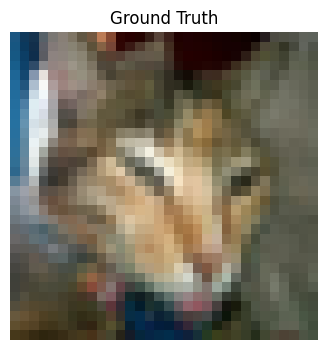

In [ ]:
img_np, coords_t, pixels_t, H, W = get_cat_data(index_=23)
plot_ground_truth(img_np)

Epoch 100/500  Loss: 0.020344
Epoch 200/500  Loss: 0.013341
Epoch 300/500  Loss: 0.011663
Epoch 400/500  Loss: 0.009935
Epoch 500/500  Loss: 0.008427


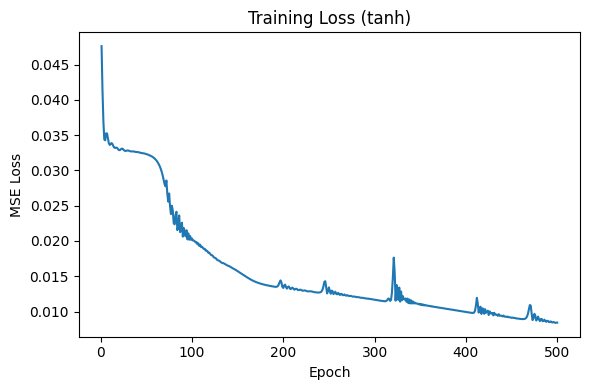

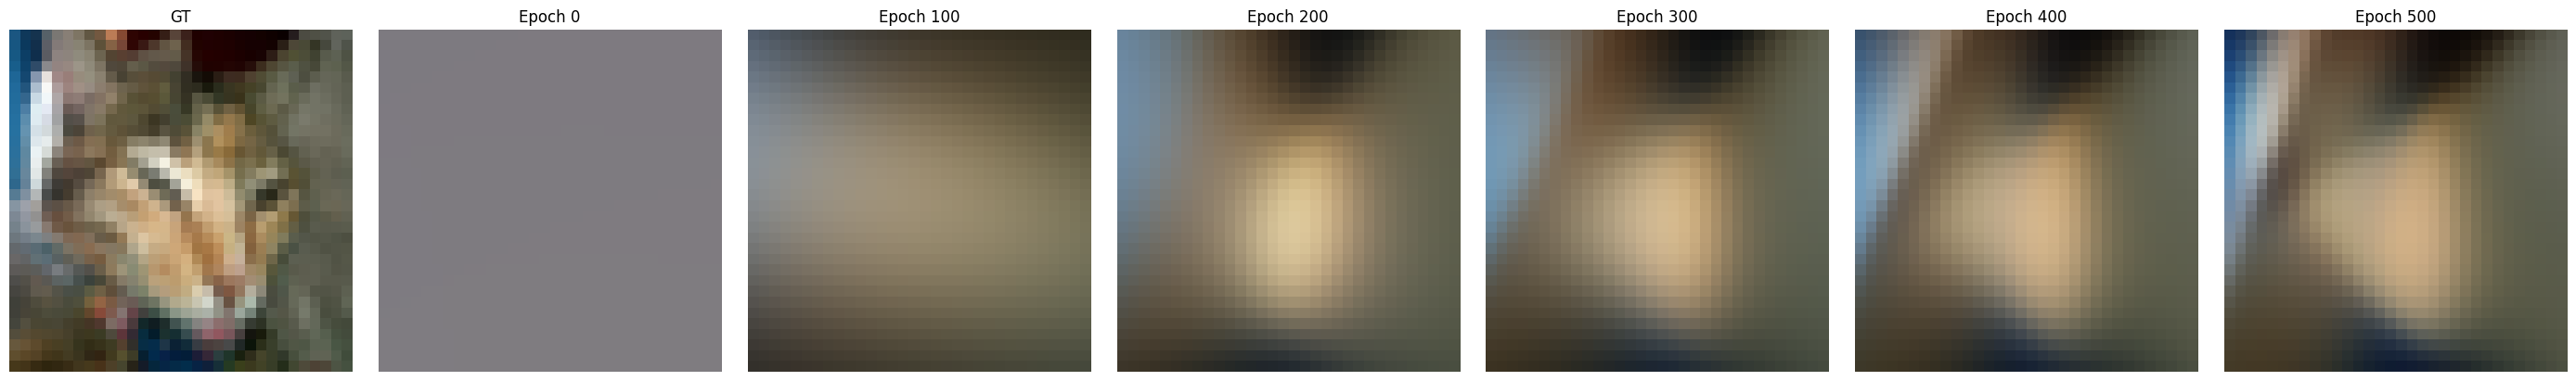

In [ ]:
run_experiment(layer_dims=[2, 128, 128,128,128, 128, 3],activation='tanh',num_epochs=500,num_snapshots=6,lr=1e-3, index_=23)

Epoch 100/500  Loss: 0.033886
Epoch 200/500  Loss: 0.033873
Epoch 300/500  Loss: 0.031225
Epoch 400/500  Loss: 0.030288
Epoch 500/500  Loss: 0.028119


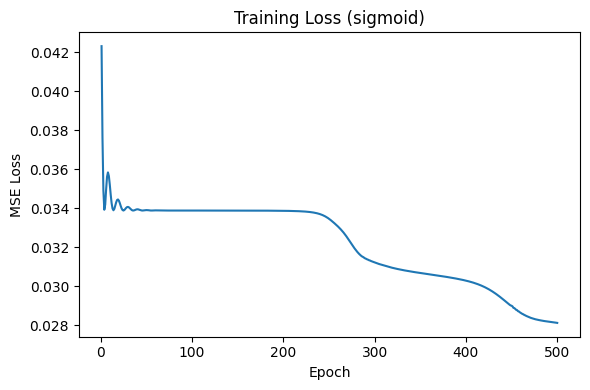

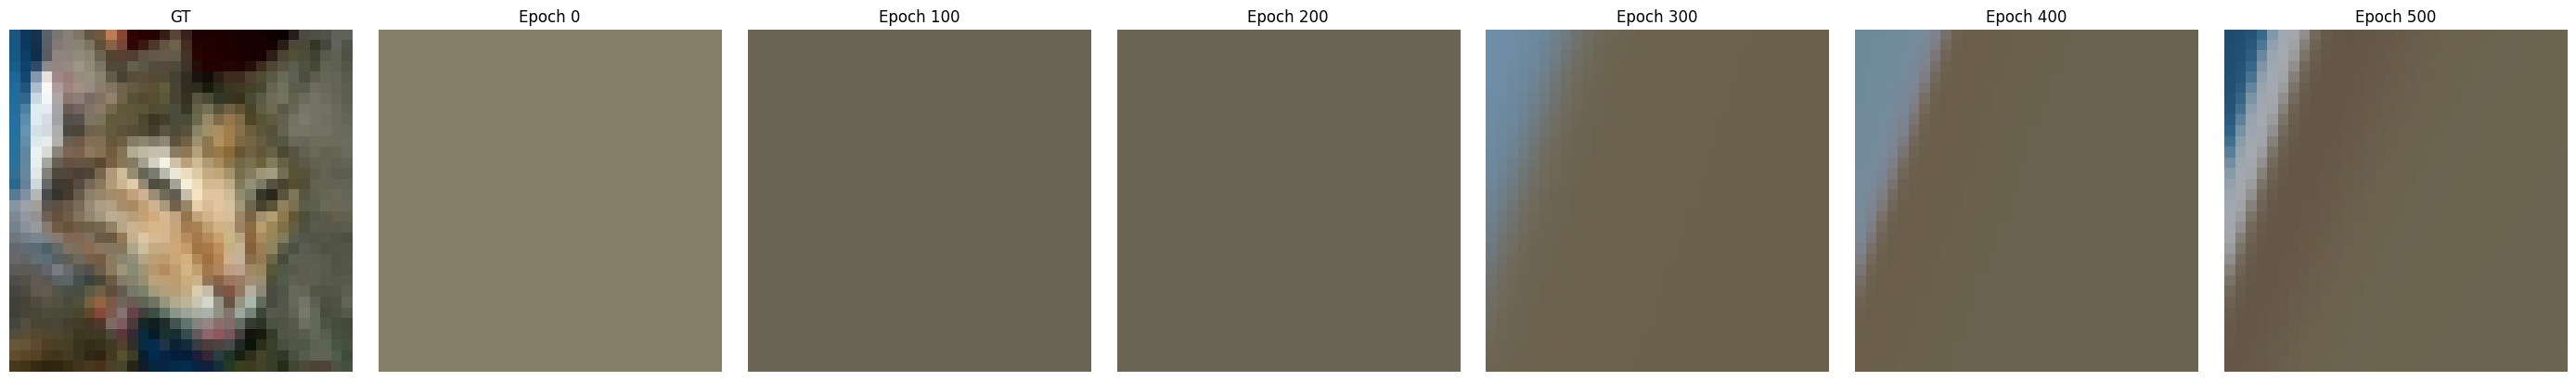

In [ ]:
run_experiment(layer_dims=[2, 128, 128,128,128, 128, 3],activation='sigmoid',num_epochs=500,num_snapshots=6,lr=1e-3, index_=23)

Epoch 100/500  Loss: 0.016337
Epoch 200/500  Loss: 0.007913
Epoch 300/500  Loss: 0.006981
Epoch 400/500  Loss: 0.005965
Epoch 500/500  Loss: 0.005396


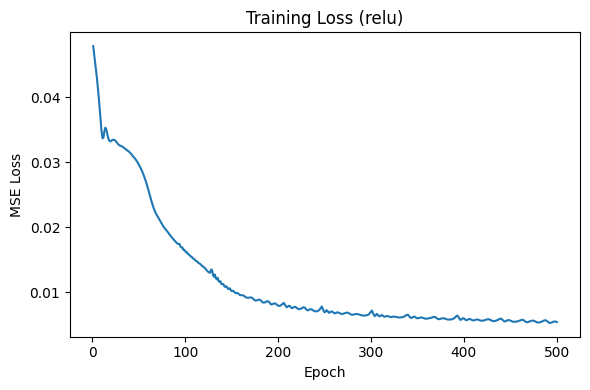

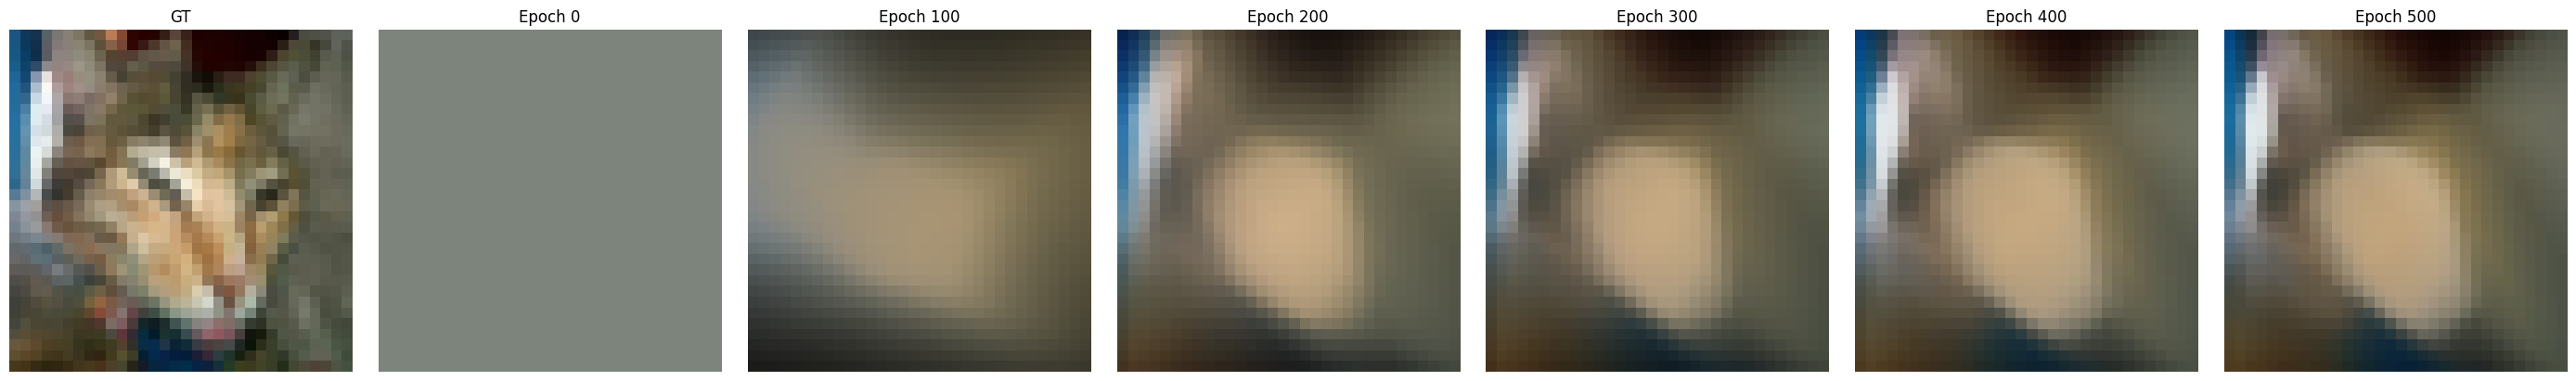

In [ ]:
run_experiment(layer_dims=[2, 128, 128,128,128, 128, 3],activation='relu',num_epochs=500,num_snapshots=6,lr=1e-3, index_=23)

Epoch 100/500  Loss: 0.003344
Epoch 200/500  Loss: 0.000582
Epoch 300/500  Loss: 0.000200
Epoch 400/500  Loss: 0.000103
Epoch 500/500  Loss: 0.000068


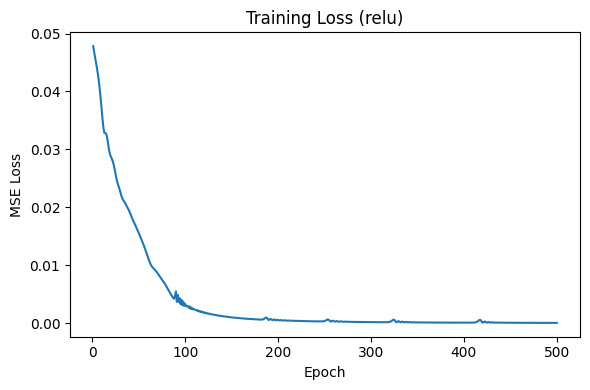

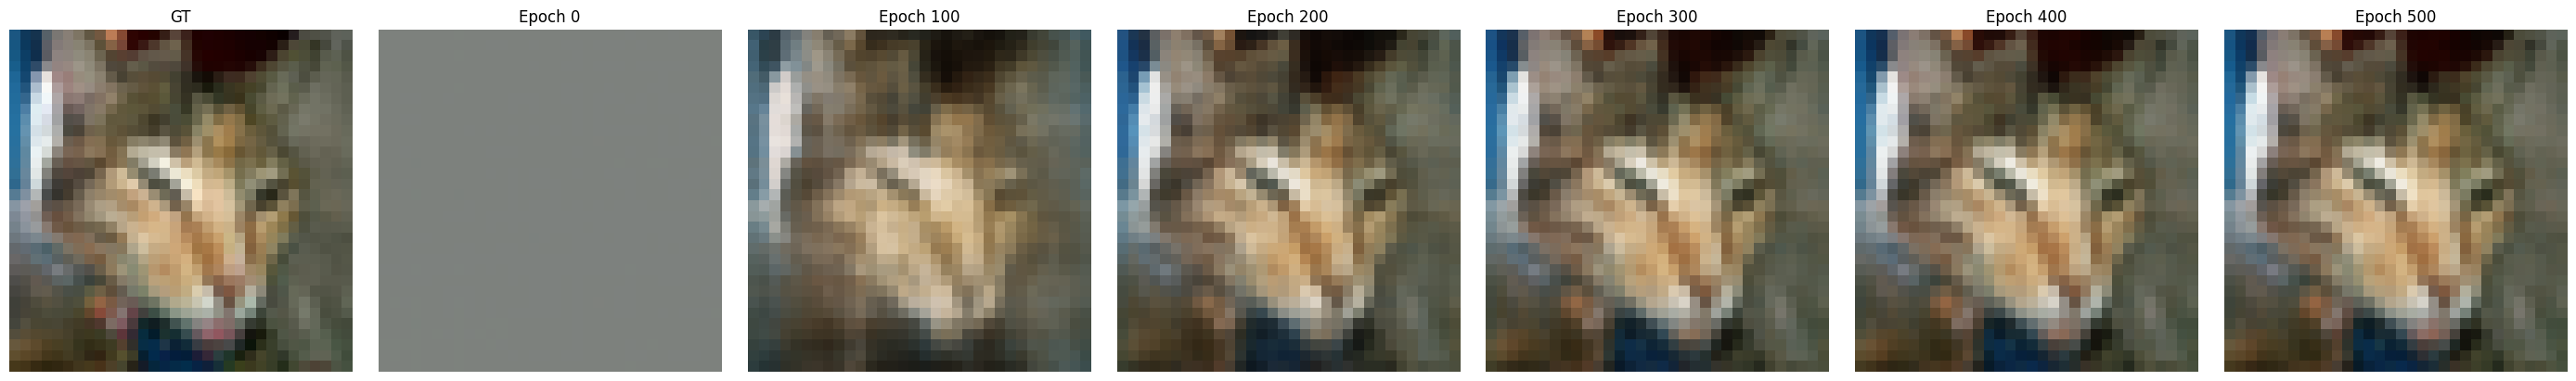

In [ ]:
run_experiment(layer_dims=[2, 128, 128,128,128, 128, 3],activation='relu',num_epochs=500,num_snapshots=6,lr=1e-3, index_=23, num_freqs=10)


## Siren


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [3]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [4]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

In [5]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_cameraman_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

In [6]:
cameraman = ImageFitting(256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

Step 0, Total loss 0.322510


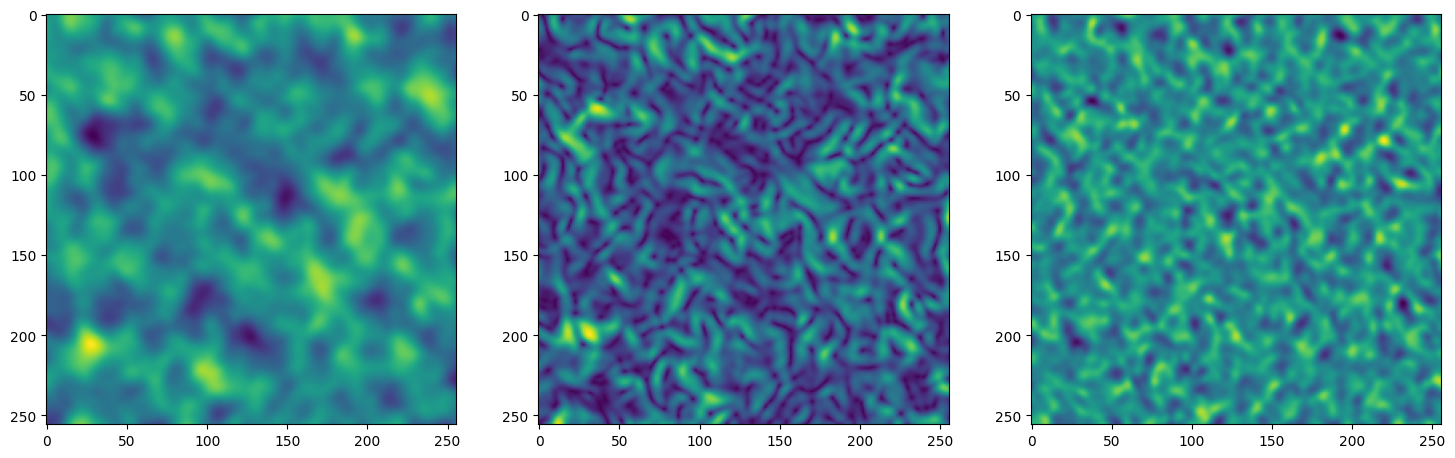

Step 50, Total loss 0.011967


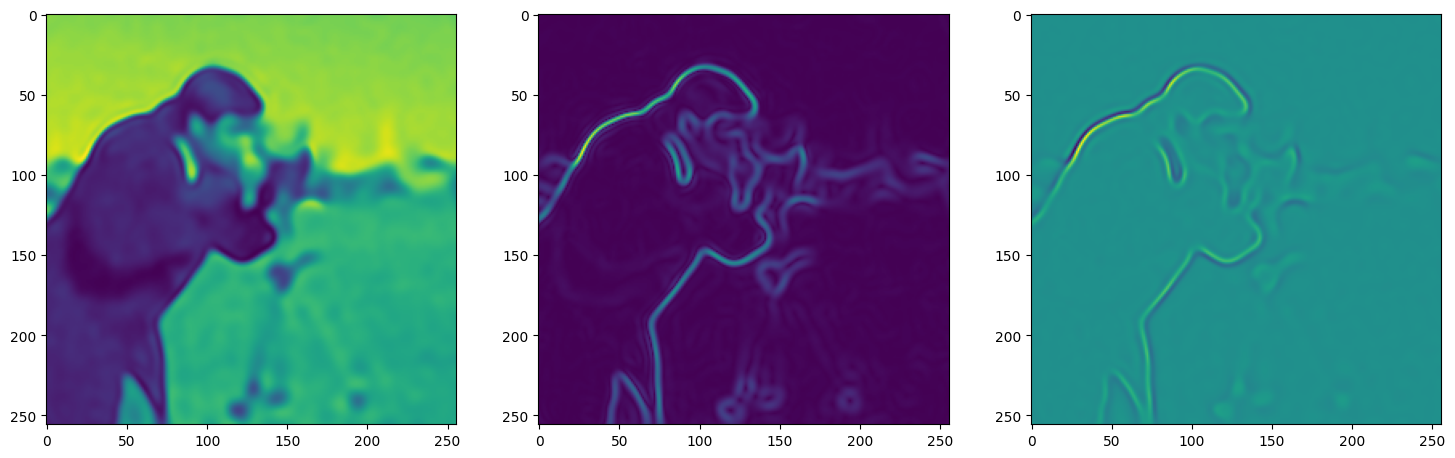

Step 100, Total loss 0.008138


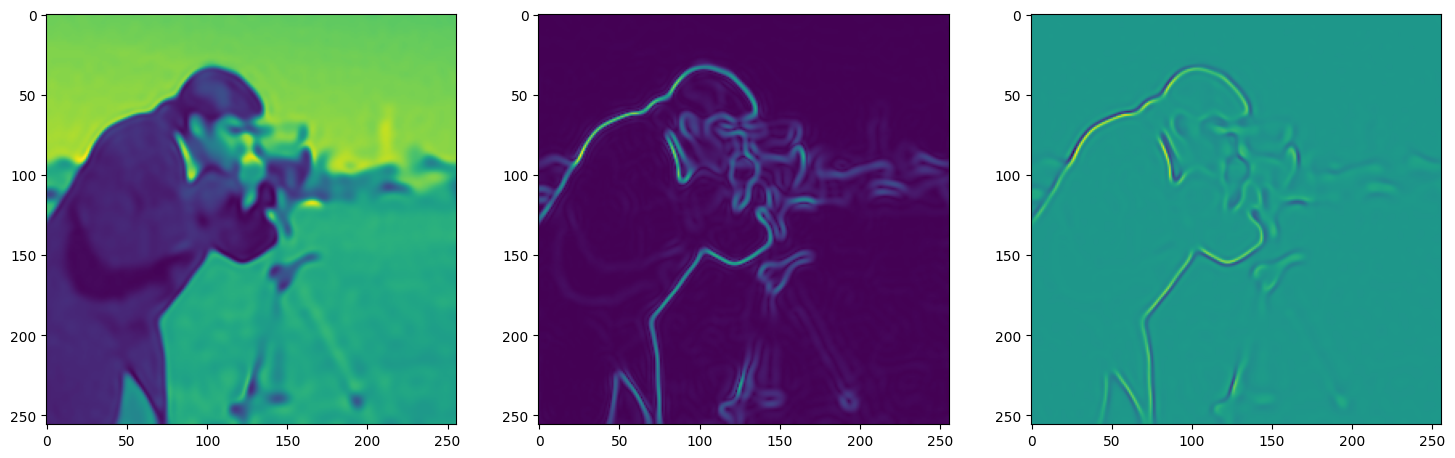

Step 150, Total loss 0.005792


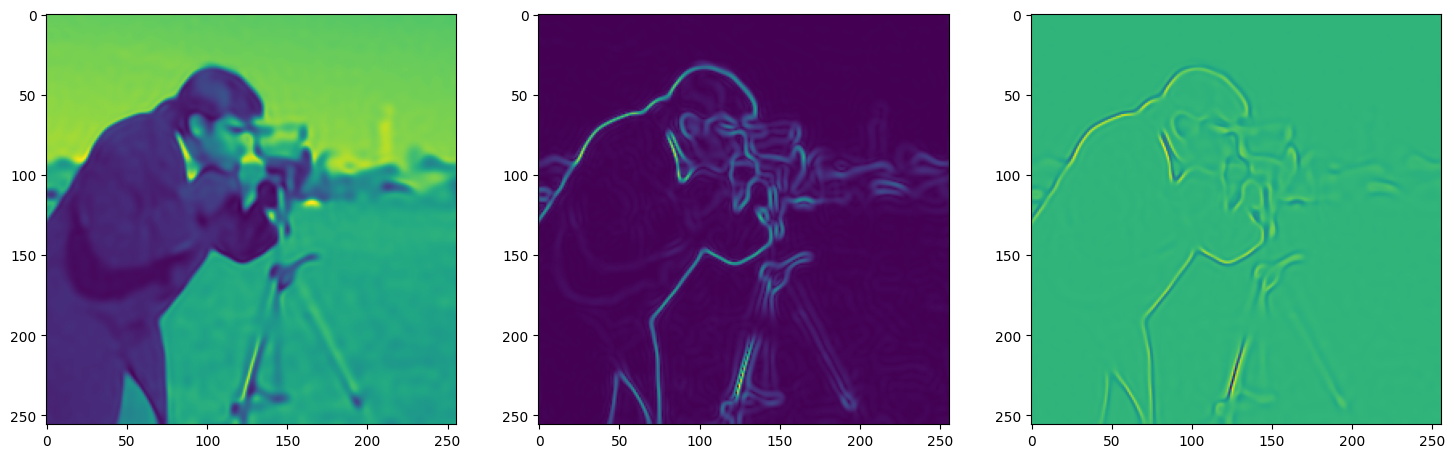

Step 200, Total loss 0.004006


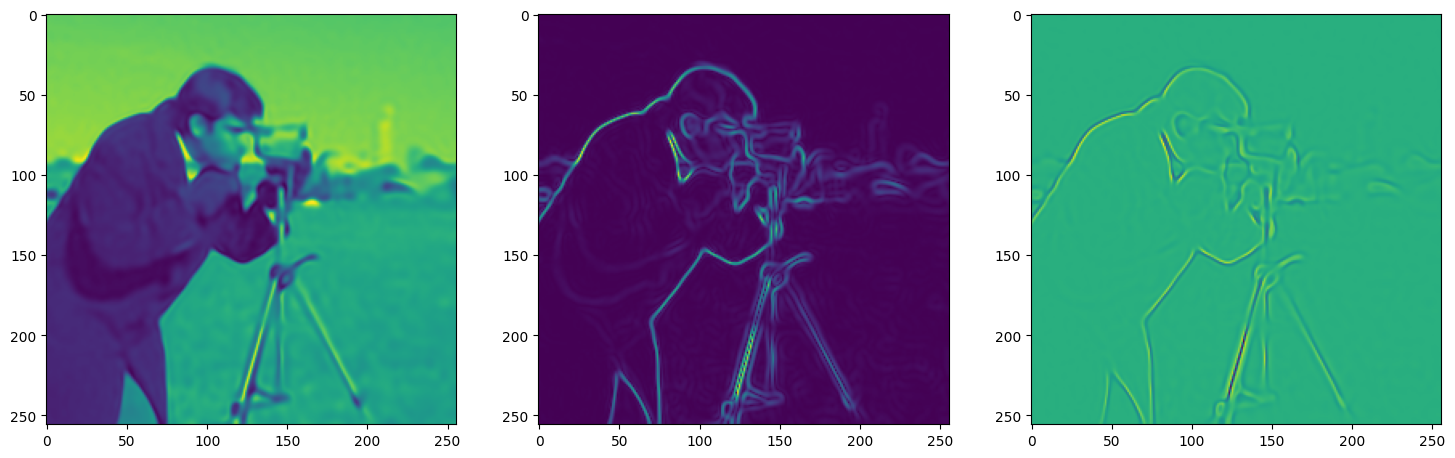

Step 250, Total loss 0.002569


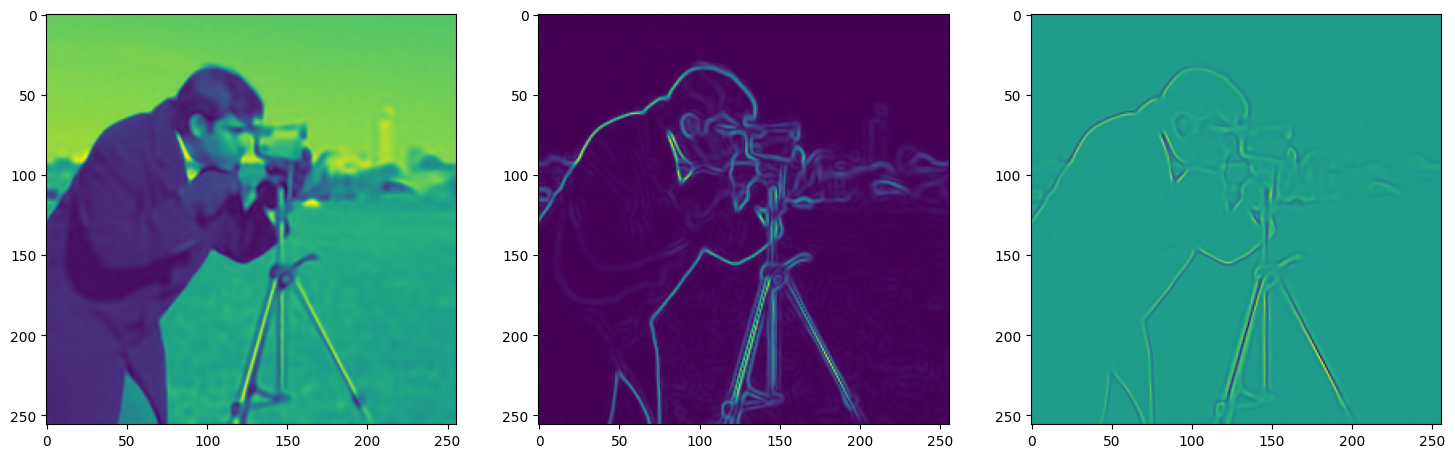

Step 300, Total loss 0.001971


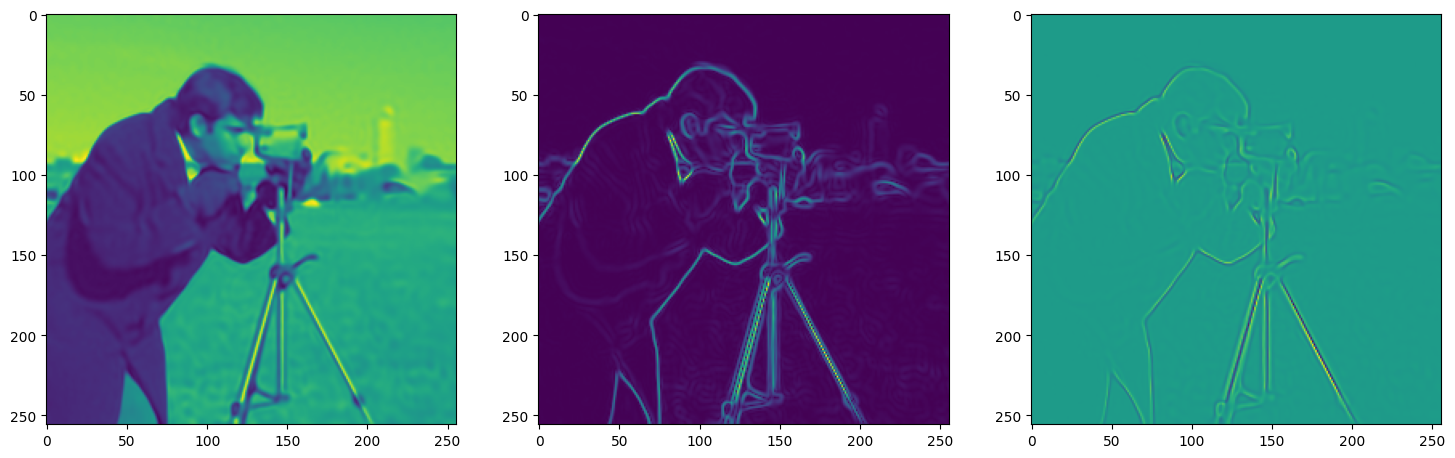

Step 350, Total loss 0.001602


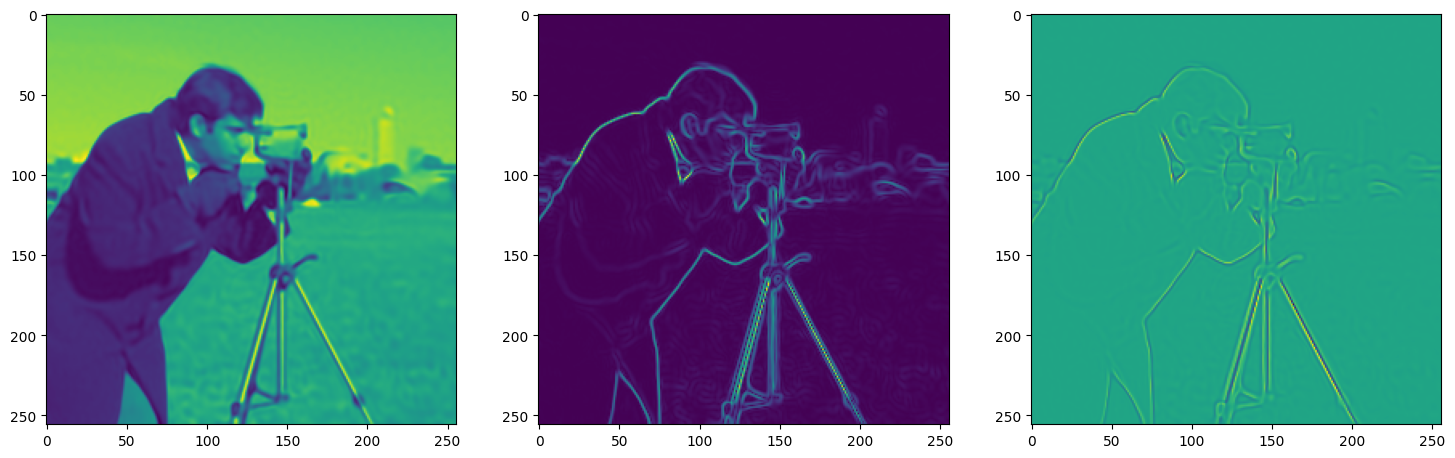

Step 400, Total loss 0.001353


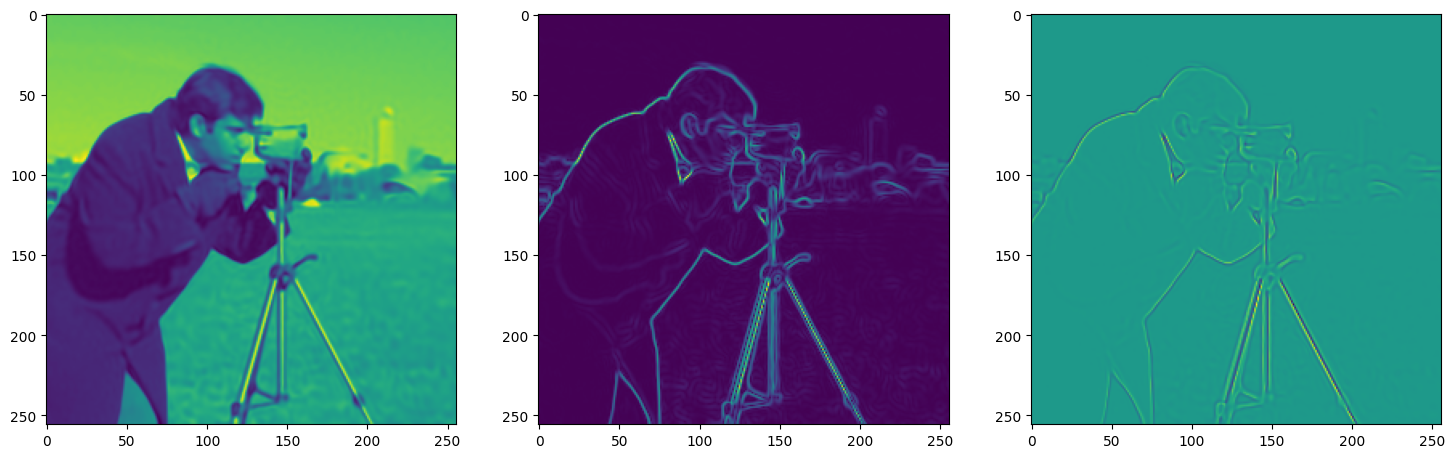

Step 450, Total loss 0.001179


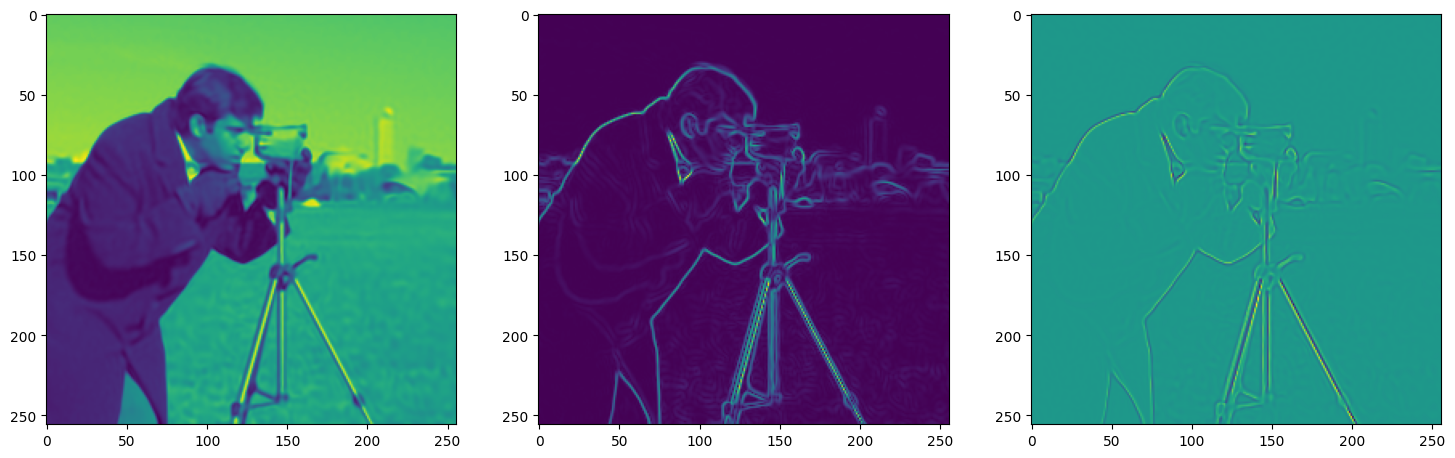

In [7]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 50

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = img_siren(model_input)
    loss = ((model_output - ground_truth)**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(256,256).detach().numpy())
        axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256,256).detach().numpy())
        axes[2].imshow(img_laplacian.cpu().view(256,256).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()